# Article Title Generation Model with T5

## Libraries and dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
!pip install datasets transformers rouge-score nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 64.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6

In [ ]:
!kaggle

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!cp kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d fabiochiusano/medium-articles

100% 368M/369M [00:21<00:00, 22.4MB/s]
100% 369M/369M [00:21<00:00, 18.1MB/s]


## Load the dataset

In [ ]:
import transformers
import numpy as np
import torch
from datasets import load_dataset, load_metric

In [ ]:
medium_datasets = load_dataset("csv", data_files="medium-articles.zip")
qa_dataset = load_dataset("squad")


  0%|          | 0/1 [00:00<?, ?it/s]

## Dataset train/validation/test split

### Text summarization dataset

In [ ]:
datasets_train_test = medium_datasets["train"].train_test_split(test_size=300)
datasets_train_validation = datasets_train_test["train"].train_test_split(test_size=300)

medium_datasets["train"] = datasets_train_validation["train"]
medium_datasets["validation"] = datasets_train_validation["test"]
medium_datasets["test"] = datasets_train_test["test"]

medium_datasets

DatasetDict({
    train: Dataset({
        features: ['title', 'text', 'url', 'authors', 'timestamp', 'tags'],
        num_rows: 191768
    })
    validation: Dataset({
        features: ['title', 'text', 'url', 'authors', 'timestamp', 'tags'],
        num_rows: 300
    })
    test: Dataset({
        features: ['title', 'text', 'url', 'authors', 'timestamp', 'tags'],
        num_rows: 300
    })
})

In [ ]:
n_samples_train = len(medium_datasets["train"])
n_samples_validation = len(medium_datasets["validation"])
n_samples_test = len(medium_datasets["test"])
n_samples_total = n_samples_train + n_samples_validation + n_samples_test

print(f"- Training set: {n_samples_train*100/n_samples_total:.2f}%")
print(f"- Validation set: {n_samples_validation*100/n_samples_total:.2f}%")
print(f"- Test set: {n_samples_test*100/n_samples_total:.2f}%")

- Training set: 99.69%
- Validation set: 0.16%
- Test set: 0.16%


In [ ]:
medium_datasets["train"]

Dataset({
    features: ['title', 'text', 'url', 'authors', 'timestamp', 'tags'],
    num_rows: 191768
})

In [ ]:
medium_datasets["train"] = medium_datasets["train"].shuffle().select(range(10000))
medium_datasets["validation"] = medium_datasets["validation"].shuffle().select(range(300))
medium_datasets["test"] = medium_datasets["test"].shuffle().select(range(300))

medium_datasets

DatasetDict({
    train: Dataset({
        features: ['title', 'text', 'url', 'authors', 'timestamp', 'tags'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['title', 'text', 'url', 'authors', 'timestamp', 'tags'],
        num_rows: 300
    })
    test: Dataset({
        features: ['title', 'text', 'url', 'authors', 'timestamp', 'tags'],
        num_rows: 300
    })
})

### Question-answering dataset

In [ ]:
datasets_train_test = qa_dataset["train"].train_test_split(test_size=5070)
qa_dataset["train"] = datasets_train_test["train"]
qa_dataset["test"] = datasets_train_test["test"]

qa_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 82529
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 5070
    })
})

In [ ]:
n_samples_train = len(qa_dataset["train"])
n_samples_validation = len(qa_dataset["validation"])
n_samples_test = len(qa_dataset["test"])
n_samples_total = n_samples_train + n_samples_validation + n_samples_test

print(f"- Training set: {n_samples_train*100/n_samples_total:.2f}%")
print(f"- Validation set: {n_samples_validation*100/n_samples_total:.2f}%")
print(f"- Test set: {n_samples_test*100/n_samples_total:.2f}%")

- Training set: 84.07%
- Validation set: 10.77%
- Test set: 5.16%


In [ ]:
qa_dataset["train"] = qa_dataset["train"].shuffle().select(range(5300))
qa_dataset["validation"] = qa_dataset["validation"].shuffle().select(range(300))
qa_dataset["test"] = qa_dataset["test"].shuffle().select(range(300))

qa_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 5300
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 300
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 300
    })
})

In [ ]:
qa_dataset['train'][1]

{'id': '5709bd0d200fba14003682a0',
 'title': 'United_States_dollar',
 'context': 'The word "dollar" is one of the words in the first paragraph of Section 9 of Article 1 of the U.S. Constitution. In that context, "dollars" is a reference to the Spanish milled dollar, a coin that had a monetary value of 8 Spanish units of currency, or reales. In 1792 the U.S. Congress adopted legislation titled An act establishing a mint, and regulating the Coins of the United States. Section 9 of that act authorized the production of various coins, including "DOLLARS OR UNITS—each to be of the value of a Spanish milled dollar as the same is now current, and to contain three hundred and seventy-one grains and four sixteenth parts of a grain of pure, or four hundred and sixteen grains of standard silver". Section 20 of the act provided, "That the money of account of the United States shall be expressed in dollars, or units... and that all accounts in the public offices and all proceedings in the courts of

## Data preprocessing

In [ ]:
import nltk
nltk.download('punkt')
import string
from transformers import AutoTokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
model_checkpoint = "t5-base"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [ ]:
prefix = "summarize: "

max_input_length = 800
max_target_length = 64

def clean_text(text):
    sentences = nltk.sent_tokenize(text.strip())
    sentences_cleaned = [s for sent in sentences for s in sent.split("\n")]
    sentences_cleaned_no_titles = [sent for sent in sentences_cleaned
                                     if len(sent) > 0 and
                                     sent[-1] in string.punctuation]
    text_cleaned = "\n".join(sentences_cleaned_no_titles)
    return text_cleaned

def preprocess_summarize_data(examples):
    texts_cleaned = [clean_text(text) for text in examples["text"]]
    inputs = [prefix + text for text in texts_cleaned]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["title"], max_length=max_target_length, 
                           truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

def encode_examples_qa(example):
    example['input_text'] = 'question: %s  context: %s' % (example["question"], example["context"])
    example['target_text'] = '%s' % example['answers']['text'][0]
    return example

def feat_converter_qa(example_batch):
    model_inputs = tokenizer(example_batch['input_text'], max_length=max_input_length, truncation=True)

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(example_batch["target_text"], max_length=max_target_length, 
                       truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
medium_datasets_cleaned = medium_datasets.filter(lambda example: (len(example['text']) >= 500) and (len(example['title']) >= 20))
summarize_tokenized_datasets = medium_datasets_cleaned.map(preprocess_summarize_data, batched=True)
summarize_tokenized_datasets

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

Filter:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/8553 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3606: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/256 [00:00<?, ? examples/s]

Map:   0%|          | 0/258 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['title', 'text', 'url', 'authors', 'timestamp', 'tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 8553
    })
    validation: Dataset({
        features: ['title', 'text', 'url', 'authors', 'timestamp', 'tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 256
    })
    test: Dataset({
        features: ['title', 'text', 'url', 'authors', 'timestamp', 'tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 258
    })
})

In [ ]:
qa_dataset_cleaned = qa_dataset.filter(lambda example: (len(example['context']) >= 400) and (len(example['title']) >= 5))
qa_tokenized_datasets_en = qa_dataset_cleaned.map(encode_examples_qa)
qa_tokenized_datasets = qa_tokenized_datasets_en.map(feat_converter_qa, batched=True)

qa_tokenized_datasets

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/4655 [00:00<?, ?ex/s]

  0%|          | 0/274 [00:00<?, ?ex/s]

  0%|          | 0/262 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers', 'input_text', 'target_text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 4655
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers', 'input_text', 'target_text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 274
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers', 'input_text', 'target_text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 262
    })
})

In [ ]:
qa_tokenized_datasets['validation'][0]['input_text'], qa_tokenized_datasets['validation'][0]['labels'], qa_tokenized_datasets['validation'][0]['target_text'] 

("question: Who defeated the rebels at the Battle of Frankenhausen?  context: Without Luther's backing for the uprising, many rebels laid down their weapons; others felt betrayed. Their defeat by the Swabian League at the Battle of Frankenhausen on 15 May 1525, followed by Müntzer's execution, brought the revolutionary stage of the Reformation to a close. Thereafter, radicalism found a refuge in the anabaptist movement and other religious movements, while Luther's Reformation flourished under the wing of the secular powers.",
 [17085, 12032, 3815, 1],
 'Swabian League')

## Fine-tune T5

In [ ]:
!pip uninstall -y transformers accelerate
!pip install transformers accelerate

Found existing installation: transformers 4.29.2
Uninstalling transformers-4.29.2:
  Successfully uninstalled transformers-4.29.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.29.2-py3-none-any.whl (7.1 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 22.7 MB/s eta 0:00:00


In [ ]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

In [ ]:
def get_args(model, monitoring_metric):
    model_dir = f"drive/MyDrive/Models/{model}"
    args = Seq2SeqTrainingArguments(
        model_dir,
        evaluation_strategy="steps",
        eval_steps=50,
        logging_strategy="steps",
        logging_steps=50,
        save_strategy="steps",
        save_steps=200,
        learning_rate=4e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        weight_decay=0.01,
        save_total_limit=3,
        num_train_epochs=1,
        predict_with_generate=True,
        fp16=True,
        load_best_model_at_end=True,
        metric_for_best_model=monitoring_metric,
        report_to="tensorboard"
    )
    return args

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer)

In [ ]:
import numpy as np
import nltk
import string
import re
from collections import Counter

metric_sum = load_metric("rouge")

def compute_metrics_sum(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)


    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip()))
                      for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) 
                      for label in decoded_labels]
    
    result = metric_sum.compute(predictions=decoded_preds, references=decoded_labels,
                            use_stemmer=True)

    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id)
                      for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

def normalize_answer(s):
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)
    def white_space_fix(text):
        return ' '.join(text.split())
    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)
    def lower(text):
        return text.lower()
    return white_space_fix(remove_articles(remove_punc(lower(s))))


def f1_score(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()

    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


def exact_match_score(prediction, ground_truth):
    return (normalize_answer(prediction) == normalize_answer(ground_truth))

def evaluate(gold_answers, predictions):
    f1 = exact_match = total = 0

    for ground_truth, prediction in zip(gold_answers, predictions):
        total += 1
        exact_match += exact_match_score(prediction, ground_truth)
        f1 += f1_score(prediction, ground_truth)
    
    exact_match = 100.0 * exact_match / total
    f1 = 100.0 * f1 / total

    return {'exact_match': exact_match, 'f1': f1}

def compute_metrics_qa(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    return evaluate(decoded_labels, decoded_preds)

<ipython-input-15-e2dc92b4773d>:7: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric_sum = load_metric("rouge")


### **Text summarization task**

In [ ]:
def model_init():
    model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
    return model

model_name = "t5-base-medium-title-generation"
args = get_args(model_name, 'rouge1')
trainer = Seq2SeqTrainer(
    model_init=model_init,
    args=args,
    train_dataset=summarize_tokenized_datasets["train"],
    eval_dataset=summarize_tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_sum
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
50,3.340300,2.614455,25.167500,12.469800,22.967000,22.999900,15.046900
100,2.746400,2.494493,29.052000,14.839900,26.582500,26.612300,12.613300
150,2.799700,2.446431,30.121800,15.823200,28.058100,28.157000,12.097700
200,2.592500,2.437168,30.904000,16.630600,28.746600,28.862700,11.293000
250,2.766900,2.408926,29.803800,15.825400,27.482200,27.649200,11.988300
300,2.650900,2.397045,31.384800,16.262100,29.135900,29.230800,11.269500
350,2.433300,2.397474,31.208500,16.650900,28.821200,29.079000,12.078100
400,2.603400,2.397527,31.709500,16.603800,29.278700,29.464100,11.710900
450,2.635600,2.384417,30.822000,16.198300,28.746700,28.912500,11.988300
500,2.657700,2.376637,31.683900,16.512800,29.733800,29.868800,11.433600


TrainOutput(global_step=1070, training_loss=2.6624976969210903, metrics={'train_runtime': 1935.6157, 'train_samples_per_second': 4.419, 'train_steps_per_second': 0.553, 'total_flos': 8135868906593280.0, 'train_loss': 2.6624976969210903, 'epoch': 1.0})

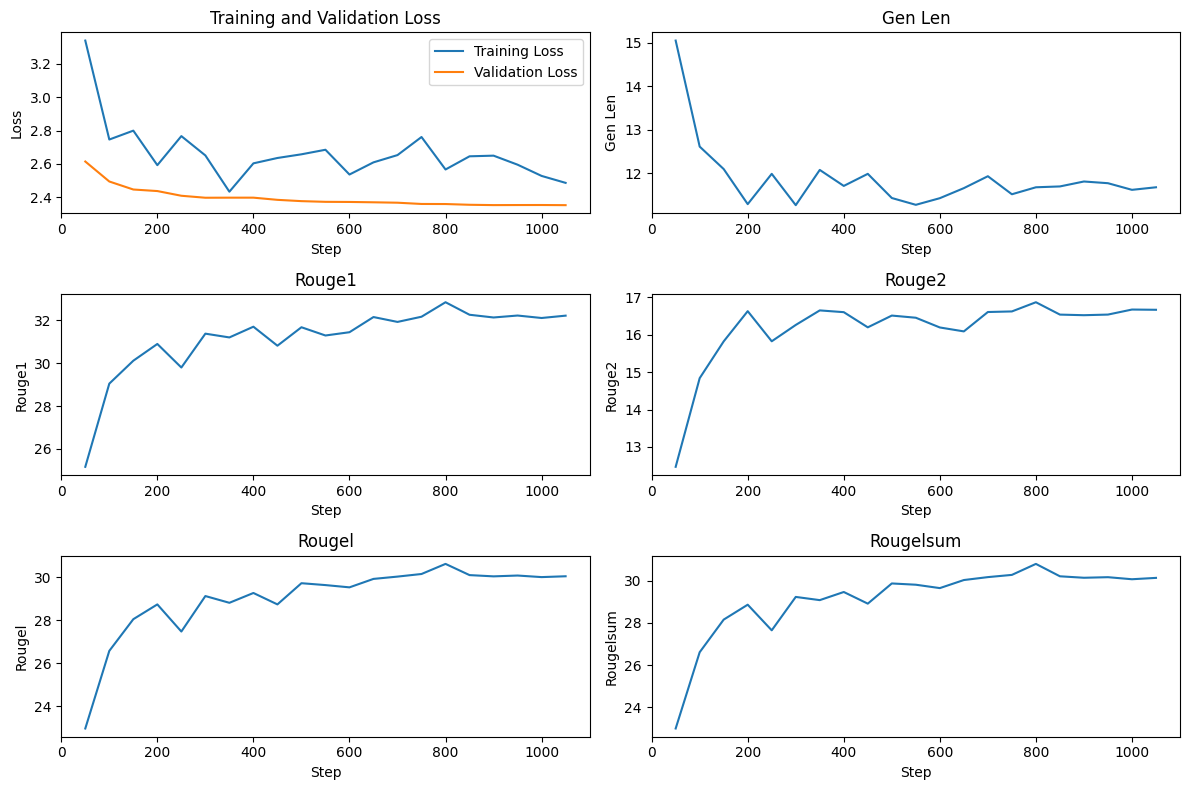

In [ ]:
history = pd.DataFrame(transformers.modelcard.parse_log_history(trainer.state.log_history)[1])

def plot_history(history):
    fig, axes = plt.subplots(3, 2, figsize=(12, 8))

    axes[0, 0].plot(history['Step'], history['Training Loss'], label='Training Loss')
    axes[0, 0].plot(history['Step'], history['Validation Loss'], label='Validation Loss')
    axes[0, 0].set_xlabel('Step')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()

    metrics = ['Gen Len', 'Rouge1', 'Rouge2', 'Rougel', 'Rougelsum']

    for i, metric in enumerate(metrics, start=1):
        ax = axes[i // 2, i % 2]
        ax.plot(history['Step'], history[metric])
        ax.set_xlabel('Step')
        ax.set_ylabel(metric)
        ax.set_title(metric)

    plt.tight_layout()
    plt.show()

plot_history(history)

In [ ]:
history.columns

Index(['Training Loss', 'Epoch', 'Step', 'Validation Loss', 'Rouge1', 'Rouge2',
       'Rougel', 'Rougelsum', 'Gen Len'],
      dtype='object')

In [ ]:
trainer.save_model()

### **QA task**

In [ ]:
def model_init():
    model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
    return model

model_name = "t5-base-qa-task"
args = get_args(model_name, 'f1')
trainer = Seq2SeqTrainer(
    model_init=model_init,
    args=args,
    train_dataset=qa_tokenized_datasets["train"],
    eval_dataset=qa_tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_qa
)

In [ ]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Exact Match,F1
100,0.251300,0.406584,66.058394,80.358206
200,0.240700,0.385958,66.058394,79.946974
300,0.250200,0.389894,66.788321,80.190983
400,0.248100,0.382872,67.153285,80.339180
500,0.244000,0.389262,66.788321,80.305444


TrainOutput(global_step=582, training_loss=0.24449724020417204, metrics={'train_runtime': 329.9241, 'train_samples_per_second': 14.109, 'train_steps_per_second': 1.764, 'total_flos': 1790066211056640.0, 'train_loss': 0.24449724020417204, 'epoch': 1.0})

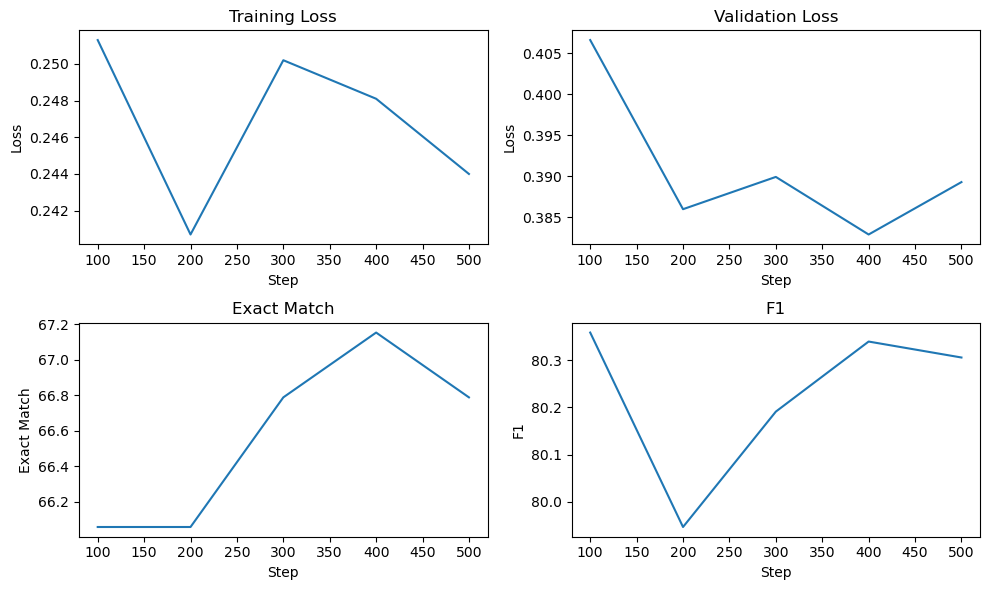

In [ ]:
history = pd.DataFrame(transformers.modelcard.parse_log_history(trainer.state.log_history)[1])
def plot_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(10, 6))

    axes[0, 0].plot(history['Step'], history['Training Loss'], label='Training Loss')
    axes[0, 1].plot(history['Step'], history['Validation Loss'], label='Validation Loss')
    axes[0, 0].set_xlabel('Step')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 1].set_xlabel('Step')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 0].set_title('Training Loss')
    axes[0, 1].set_title('Validation Loss')

    metrics = ['Exact Match', 'F1']

    for i, metric in enumerate(metrics):
        ax = axes[i // 2+1, i % 2]
        ax.plot(history['Step'], history[metric])
        ax.set_xlabel('Step')
        ax.set_ylabel(metric)
        ax.set_title(metric)

    plt.tight_layout()
    plt.show()

plot_history(history)

In [ ]:
history.columns

Index(['Training Loss', 'Epoch', 'Step', 'Validation Loss', 'Exact Match',
       'F1'],
      dtype='object')

In [ ]:
trainer.save_model()

**Text summarization model uploading**

In [ ]:
model_name = "t5-base-medium-title-generation/checkpoint-1000"
model_dir = f"drive/MyDrive/Models/{model_name}"

tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSeq2SeqLM.from_pretrained(model_dir)

max_input_length = 512

**QA model uploading**

In [ ]:
model_name = "t5-base-qa-task/checkpoint-400"
model_dir = f"drive/MyDrive/Models/{model_name}"

tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSeq2SeqLM.from_pretrained(model_dir)

max_input_length = 512

## Evaluation

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
device

device(type='cuda')

**Summarization task**

In [ ]:
test_sum_tokenized_dataset = summarize_tokenized_datasets["test"]

def preprocess_test_sum(examples):
    inputs = [prefix + text for text in examples["text"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True,
                           padding="max_length")
    return model_inputs

test_sum_tokenized_dataset = test_sum_tokenized_dataset.map(preprocess_test_sum, batched=True)

test_sum_tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])
dataloader = torch.utils.data.DataLoader(test_sum_tokenized_dataset, batch_size=32)

all_predictions = []
for i,batch in enumerate(dataloader):
    batch = {key: value.to(device) for key, value in batch.items()}
    predictions = model.generate(**batch)
    all_predictions.append(predictions)

all_predictions_flattened = [pred for preds in all_predictions for pred in preds]

all_titles = tokenizer(test_sum_tokenized_dataset["title"], max_length=max_target_length,
                       truncation=True, padding="max_length")["input_ids"]

predictions_labels = [all_predictions_flattened, all_titles]
compute_metrics_sum(predictions_labels)

Map:   0%|          | 0/258 [00:00<?, ? examples/s]

{'rouge1': 42.359,
 'rouge2': 29.7362,
 'rougeL': 40.4393,
 'rougeLsum': 40.5822,
 'gen_len': 12.0853}

In [ ]:
def get_lowest_articles(predictions_labels, compute_metrics, n=5, metric='rougeLsum'):
    predictions, labels = predictions_labels
    metric_values = []

    for i, (pred, label) in enumerate(zip(predictions, labels)):
        if i % 20 == 0:
            print(f'{i}/{len(labels)}...')
        eval_pred = [[pred], [label]]
        metrics = compute_metrics(eval_pred)
        metric_value = metrics[metric]
        metric_values.append(metric_value)

    lowest_indices = sorted(range(len(metric_values)), key=lambda i: metric_values[i])[:n]
    lowest_articles = [labels[i] for i in lowest_indices]

    return lowest_articles, lowest_indices

lowest_articles, lowest_indices = get_lowest_articles(predictions_labels, compute_metrics_sum)

lowest_indices

0/258...
20/258...
40/258...
60/258...
80/258...
100/258...
120/258...
140/258...
160/258...
180/258...
200/258...
220/258...
240/258...


[7, 11, 17, 20, 21]

In [ ]:
def predict_result(text, model, flag=False):
    if flag:
        inputs = text
    else:
        inputs = ["summarize: " + text]
    inputs = tokenizer(inputs, max_length=max_input_length, truncation=True, return_tensors="pt")
    inputs = {key: value.to(device) for key, value in inputs.items()} 

    output = model.generate(**inputs, num_beams=8, do_sample=True, min_length=10, max_length=64)
    decoded_output = tokenizer.batch_decode(output, skip_special_tokens=True)[0]
    predicted_title = nltk.sent_tokenize(decoded_output.strip())[0]

    return predicted_title


In [ ]:
text, title = summarize_tokenized_datasets["test"][11]['text'], summarize_tokenized_datasets["test"][11]['title']
text, title

("Uber’s Manifold\n\nPhoto by Dan Gold on Unsplash\n\nFor my project, I am creating an Ensemble. An Ensemble is a collection of machine learning algorithms that each individually train and predict on the same data. The advantage of an Ensemble is that it provides a range of different strategies for finding a solution and utilizes a majority vote that democratizes the classification by all the models. This is useful because whilst an individual model may predict some portions well, it may struggle on other portions of the data. Hence, an ensemble is just the machine learning version of the strength in numbers adage. In order for an ensemble to perform well, the individual models that make it up must have diversity of prediction. Diversity of prediction is a fancy way of saying that the models can’t all be predicting exactly same for the exact points, rather they should be performing well on different selections of points. This raises the question however, how do you know if the parts of

In [ ]:
predict_result(text, model)

'Uber’s Manifold Photo by Dan Gold on Unsplash'

In [ ]:
text, title = summarize_tokenized_datasets["test"][17]['text'], summarize_tokenized_datasets["test"][41]['title']
text, title

('Saving is not enough. If we want to be smart from a financial point of view, it is not enough to just save, but also to invest our money purposefully. Investing is no longer reserved for the elite, with the internet hitting scale, we can now make money work for us with a click and, in this way, our savings start creating wealth for ourselves over time. If you have never invested, you may have certain doubts or fears. This is normal for small savers: they fear losing their savings in a bad investment. However, this situation not only does not have to occur, but it is also unlikely if you follow these investment tips.\n\nSaving is not enough. If we want to be smart from a financial point of view, it is not enough to just save, but also to invest our money purposefully. Investing is no longer reserved for the elite, with the internet hitting scale, we can now make money work for us with a click and, in this way, our savings start creating wealth for ourselves over time. If you have neve

In [ ]:
predict_result(text, model)

'Saving is not enough.'

**QA task**

In [ ]:
test_qa_dataset_en = qa_tokenized_datasets_en['test']

def preprocess_test_qa(example_batch):
    
    model_inputs = tokenizer(example_batch['input_text'], max_length=max_input_length, truncation=True,
                           padding="max_length")
    return model_inputs

test_qa_tokenized_dataset = test_qa_dataset_en.map(preprocess_test_qa, batched=True)

test_qa_tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])
dataloader = torch.utils.data.DataLoader(test_qa_tokenized_dataset, batch_size=32)

all_predictions = []
for i,batch in enumerate(dataloader):
    batch = {key: value.to(device) for key, value in batch.items()}
    predictions = model.generate(**batch)
    all_predictions.append(predictions)

all_predictions_flattened = [pred for preds in all_predictions for pred in preds]

all_titles = tokenizer(test_qa_tokenized_dataset["target_text"], max_length=max_target_length,
                       truncation=True, padding="max_length")["input_ids"]

predictions_labels = [all_predictions_flattened, all_titles]
compute_metrics_qa(predictions_labels)

  0%|          | 0/1 [00:00<?, ?ba/s]

{'exact_match': 78.62595419847328, 'f1': 89.68044610684964}

In [ ]:
lowest_articles, lowest_indices = get_lowest_articles(predictions_labels, compute_metrics_qa, metric='f1')

lowest_indices

0/262...
20/262...
40/262...
60/262...
80/262...
100/262...
120/262...
140/262...
160/262...
180/262...
200/262...
220/262...
240/262...
260/262...


[21, 37, 128, 155, 169]

In [ ]:
text, title = qa_tokenized_datasets['test'][21]['input_text'], qa_tokenized_datasets['test'][21]['target_text']
text, title

('question: What establishment today contains what was known as the Warsaw Lyceum during that time?  context: In 1817 the Saxon Palace was requisitioned by Warsaw\'s Russian governor for military use, and the Warsaw Lyceum was reestablished in the Kazimierz Palace (today the rectorate of Warsaw University). Fryderyk and his family moved to a building, which still survives, adjacent to the Kazimierz Palace. During this period, Fryderyk was sometimes invited to the Belweder Palace as playmate to the son of the ruler of Russian Poland, Grand Duke Constantine; he played the piano for the Duke and composed a march for him. Julian Ursyn Niemcewicz, in his dramatic eclogue, "Nasze Przebiegi" ("Our Discourses", 1818), attested to "little Chopin\'s" popularity.',
 'Warsaw University')

In [ ]:
predict_result(text, model, flag=True)

'Kazimierz Palace (today the rectorate of Warsaw University).'

In [ ]:
text, title = qa_tokenized_datasets['test'][100]['input_text'], qa_tokenized_datasets['test'][100]['target_text']
text, title

('question: What code eventually became neglected?  context: Probably the most influential single device on the interpretation of these characters was the Teletype Model 33 ASR, which was a printing terminal with an available paper tape reader/punch option. Paper tape was a very popular medium for long-term program storage until the 1980s, less costly and in some ways less fragile than magnetic tape. In particular, the Teletype Model 33 machine assignments for codes 17 (Control-Q, DC1, also known as XON), 19 (Control-S, DC3, also known as XOFF), and 127 (Delete) became de facto standards. The Model 33 was also notable for taking the description of Control-G (BEL, meaning audibly alert the operator) literally as the unit contained an actual bell which it rang when it received a BEL character. Because the keytop for the O key also showed a left-arrow symbol (from ASCII-1963, which had this character instead of underscore), a noncompliant use of code 15 (Control-O, Shift In) interpreted a

In [ ]:
predict_result(text, model, flag=True)

'code 15 (Control-O, Shift In)'

## Test

In [ ]:
text = """
The Applied Sciences Faculty at Ukrainian Catholic University (UCU) is a dynamic 
and innovative academic hub that fosters excellence in practical education and research.
With a strong emphasis on bridging the gap between theory and practice, the faculty 
equips students with the skills and knowledge needed to thrive in today's rapidly 
evolving technological landscape. Through its diverse range of programs, including 
computer science, engineering, data analytics, and information systems, the faculty 
empowers students to become problem solvers and innovators in their respective fields. 
Faculty members, renowned for their expertise and industry experience, provide personalized 
attention and mentorship to students, ensuring a nurturing and engaging learning environment. 
With state-of-the-art facilities and cutting-edge laboratories, the faculty at UCU offers a 
vibrant platform for students to explore, experiment, and collaborate on real-world projects. 
Graduates from the Applied Sciences Faculty emerge as highly sought-after professionals, 
equipped with the practical skills and academic foundation to excel in their careers and 
make a positive impact on society.
"""

print(predict_result(text, model))

The Applied Sciences Faculty at Ukrainian Catholic University (UCU)


In [ ]:
text = """
Ukraine is a country that captivates with its stunning natural beauty and rich cultural 
heritage. From the picturesque Carpathian Mountains in the west to the serene beaches of 
the Black Sea coast in the south, Ukraine offers diverse landscapes that leave visitors in 
awe. The country is adorned with charming villages, vibrant cities, and architectural marvels, 
such as the golden-domed cathedrals of Kyiv and the historic castles of Lviv. Moreover, Ukraine's 
warm-hearted people, delicious cuisine, and colorful traditions add an extra layer of charm to 
this enchanting land, making it a truly captivating destination for travelers.
"""

print(predict_result(text, model))

Ukraine: A Country that captivates with its stunning natural beauty and rich cultural heritage


In [ ]:
text = """
question: When did Ukraine gain its independence?
context:  Ukraine declared its independence on August 24, 1991.
This marked a significant moment in the country's history and paved the way for its
development as an independent nation..
"""
print(predict_result(text, model, False))

August 24, 1991.


In [ ]:
text="""
question: What are the main industries in Ukraine?
context: Ukraine has a diverse economy withvarious industries contributing to its growth.
Some of the main industries in Ukraine include agriculture, manufacturing, energy, information
technology, and services. The country is known for its fertile agricultural land, producing crops 
such as wheat, corn, and sunflower seeds.
"""
print(predict_result(text, model, False))

agriculture, manufacturing, energy, information technology, and services
